In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

import wrangle as wr
import explore as ex
import model as mod

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [8]:
def wrangle_temp_data():
        
    df = pd.read_csv('GlobalLandTemperaturesByState.csv')
    
    df['dt'] = pd.to_datetime(df['dt'], infer_datetime_format=True)
    
    df = df.set_index('dt').sort_index()
    
    df = df.rename(columns={'AverageTemperature': 'avg_temp',
                    'AverageTemperatureUncertainty': 'avg_temp_uncertainty',
                    'State': 'state',
                    'Country': 'country'
                   })
    
    df = df.dropna()
    
    col_list = ['avg_temp', 'avg_temp_uncertainty']

    df = wr.remove_outliers(df, 1.5, col_list)
    
    return df

In [9]:
df = wrangle_temp_data()

In [10]:
df = df[df['state'] != 'Hawaii']

In [11]:
df = df[df['state'] != 'Alaska']

In [12]:
df = df.drop(columns='state')

In [13]:
df = df[df['country'] == 'United States']

In [14]:
df.head()

,avg_temp,avg_temp_uncertainty,country
dt,,,
1743-11-01,0.753,2.817,United States
1743-11-01,1.891,1.718,United States
1743-11-01,5.953,2.220,United States
1743-11-01,-1.222,2.001,United States
1743-11-01,-2.985,4.048,United States


In [15]:
df.tail()

,avg_temp,avg_temp_uncertainty,country
dt,,,
2013-09-01,16.121,1.322,United States
2013-09-01,15.470,1.138,United States
2013-09-01,15.748,1.070,United States
2013-09-01,17.691,0.964,United States
2013-09-01,26.408,1.112,United States


In [16]:
df = df.resample('m')[['avg_temp', 'avg_temp_uncertainty']].mean()

In [17]:
df

,avg_temp,avg_temp_uncertainty
dt,,
1743-11-30,4.544966,2.594828
1743-12-31,NaN,NaN
1744-01-31,NaN,NaN
1744-02-29,NaN,NaN
1744-03-31,NaN,NaN
...,...,...
2013-05-31,16.245122,0.216653
2013-06-30,21.406184,0.243755
2013-07-31,23.747469,0.226959


In [18]:
df['avg_temp'] = df['avg_temp'].bfill()
df['avg_temp_uncertainty'] = df['avg_temp_uncertainty'].bfill()

In [19]:
df

,avg_temp,avg_temp_uncertainty
dt,,
1743-11-30,4.544966,2.594828
1743-12-31,11.722207,2.828483
1744-01-31,11.722207,2.828483
1744-02-29,11.722207,2.828483
1744-03-31,11.722207,2.828483
...,...,...
2013-05-31,16.245122,0.216653
2013-06-30,21.406184,0.243755
2013-07-31,23.747469,0.226959


In [22]:
train, validate, test = ex.subset_time_series(df)

(1943, 2) (648, 2) (648, 2)


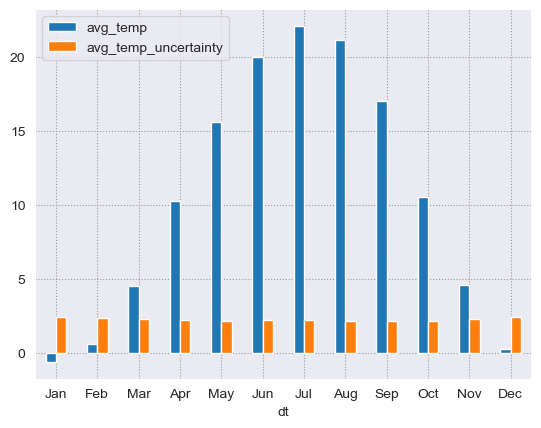

In [23]:
ax = train.groupby(train.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

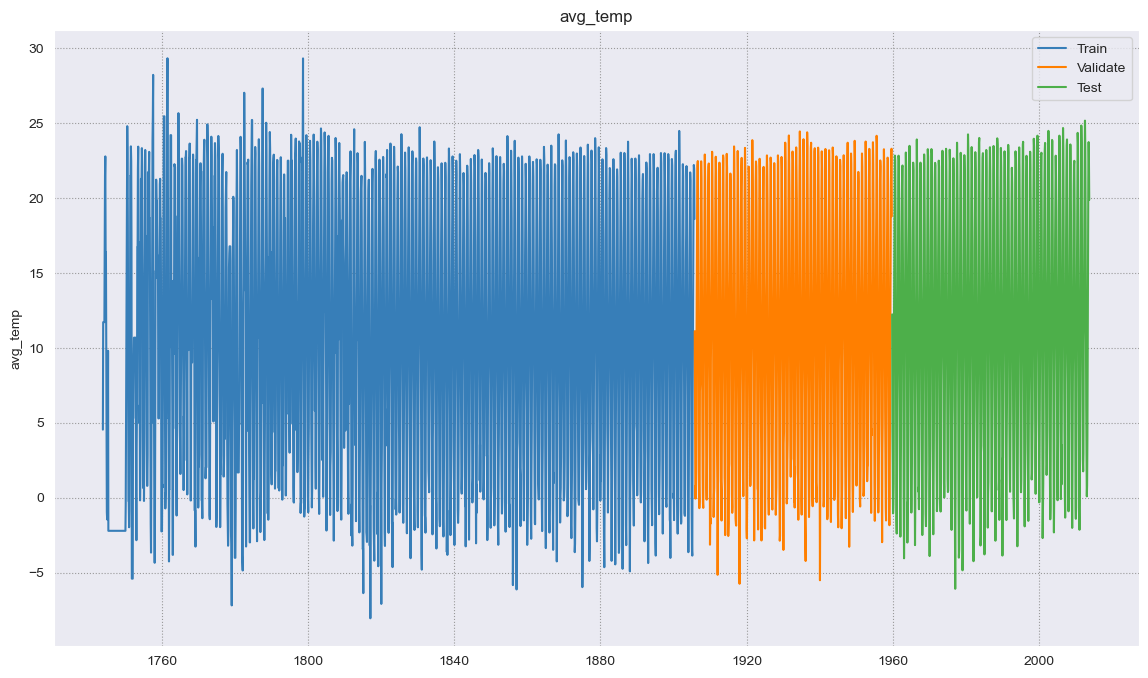

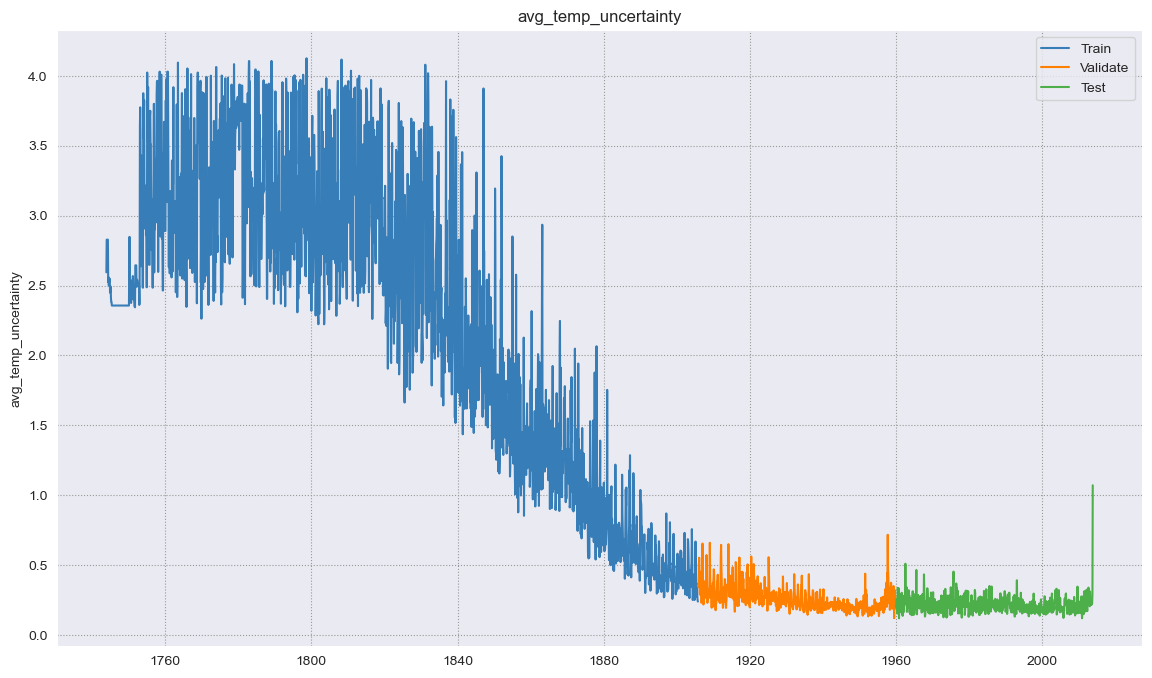

In [24]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

<AxesSubplot:xlabel='dt'>

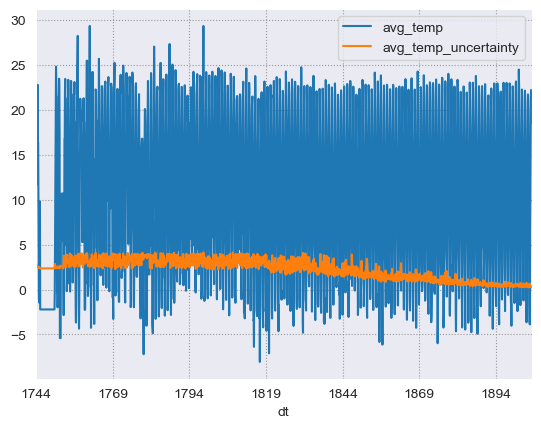

In [25]:
train.plot()

In [26]:
train.columns

Index(['avg_temp', 'avg_temp_uncertainty'], dtype='object')

In [27]:
train_shifted = train

In [28]:
train_shifted['shifted'] = train_shifted['avg_temp'].shift(-1)

In [29]:
train = train.drop(columns='shifted')

Text(0, 0.5, 'temp tomorrow')

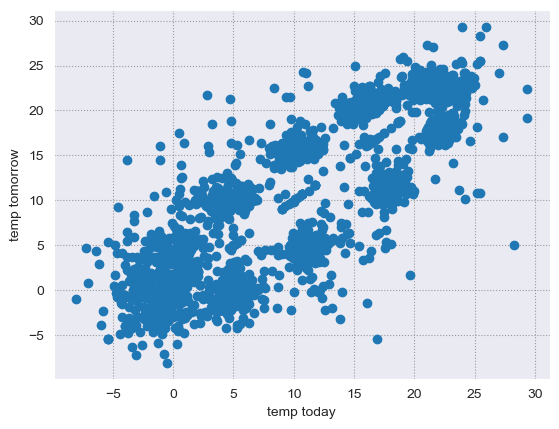

In [30]:
plt.scatter(train_shifted['avg_temp'], train_shifted['shifted'])
plt.xlabel('temp today')
plt.ylabel('temp tomorrow')

## last observed value

In [31]:
def plot_and_eval(train, validate, yhat_df, target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''        
    for col in train.columns:
        
        plt.figure(figsize = (12,4))
        plt.plot(train[col], label='Train', linewidth=1, color='#377eb8')
        plt.plot(validate[col], label='Validate', linewidth=1, color='#ff7f00')
        plt.plot(yhat_df[col], label='yhat', linewidth=2, color='#a65628')
        plt.legend()
        plt.title(col)
        rmse = evaluate(target_var, yhat_df, validate)        

        plt.show()
    

In [32]:
def make_baseline_predictions(temp_pred, uncertainty_pred):
    yhat_df = pd.DataFrame({'avg_temp': [temp_pred],
                           'avg_temp_uncertainty': [uncertainty_pred]},
                          index=validate.index)
    return yhat_df

In [33]:
def evaluate(target_var, yhat_df, validate):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 2)
    return rmse

In [34]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [35]:
last_temp = train['avg_temp'][-1:][0]
last_uncertainty = train['avg_temp_uncertainty'][-1:][0]

In [36]:
yhat_df = pd.DataFrame(
    {'avg_temp': [last_temp],
     'avg_temp_uncertainty': [last_uncertainty]},
    index=validate.index)

yhat_df.head()

,avg_temp,avg_temp_uncertainty
dt,,
1905-10-31,18.608347,0.23949
1905-11-30,18.608347,0.23949
1905-12-31,18.608347,0.23949
1906-01-31,18.608347,0.23949
1906-02-28,18.608347,0.23949


In [38]:
mod.evaluate(col, yhat_df, validate)

0.09

In [40]:
for col in train.columns:
    
    rmse = mod.evaluate(col, yhat_df, validate)
    
    eval_df = mod.append_eval_df('last_observed_value', col,
                                    eval_df, rmse)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,11.48
1,last_observed_value,avg_temp_uncertainty,0.09


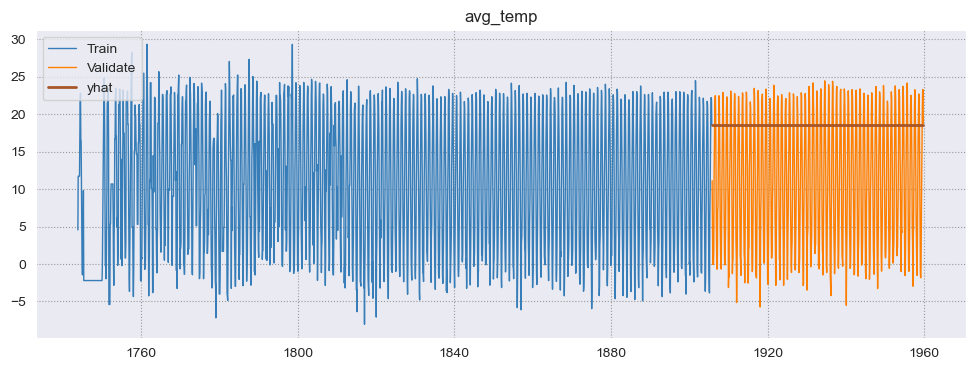

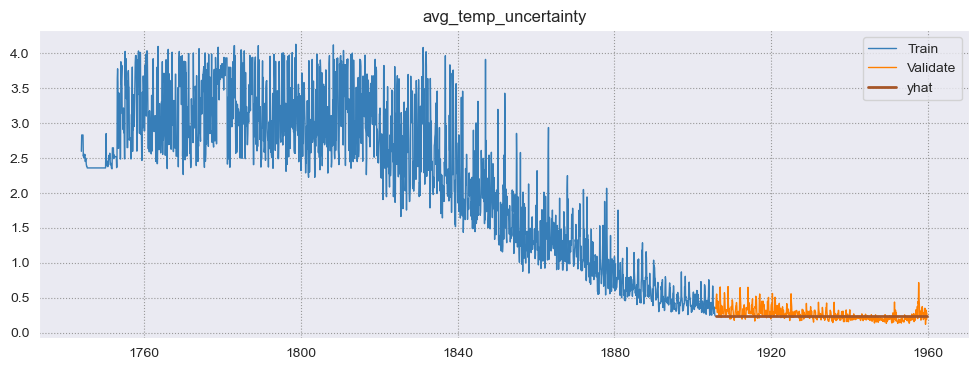

In [41]:
plot_and_eval(train, validate, yhat_df, col)

## simple average

In [42]:
avg_temps = round(train['avg_temp'].mean(), 2)
avg_temps_uncertainty = round(train['avg_temp_uncertainty'].mean(), 2)

In [43]:
yhat_df = make_baseline_predictions(avg_temps, avg_temps_uncertainty)

In [44]:
yhat_df.head()

,avg_temp,avg_temp_uncertainty
dt,,
1905-10-31,10.5,2.24
1905-11-30,10.5,2.24
1905-12-31,10.5,2.24
1906-01-31,10.5,2.24
1906-02-28,10.5,2.24


In [46]:
for col in train.columns:
    
    rmse = mod.evaluate(col, yhat_df, validate)
    
    eval_df = mod.append_eval_df('simple_average', col,
                                    eval_df, rmse)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,11.48
1,last_observed_value,avg_temp_uncertainty,0.09
2,simple_average,avg_temp,8.63
3,simple_average,avg_temp_uncertainty,1.98


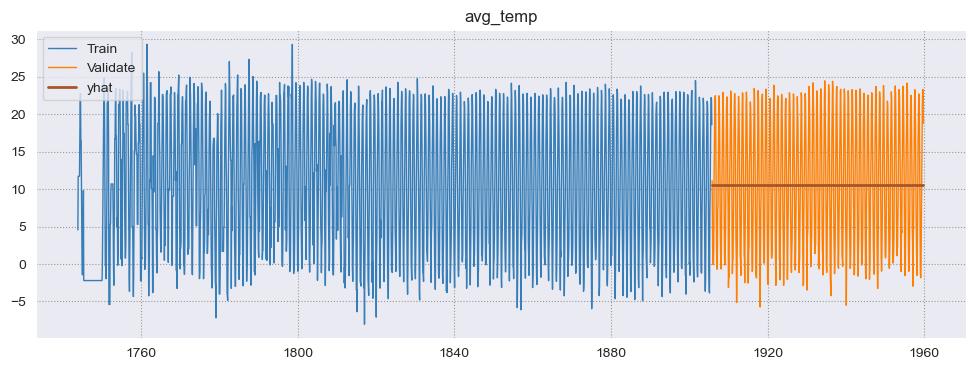

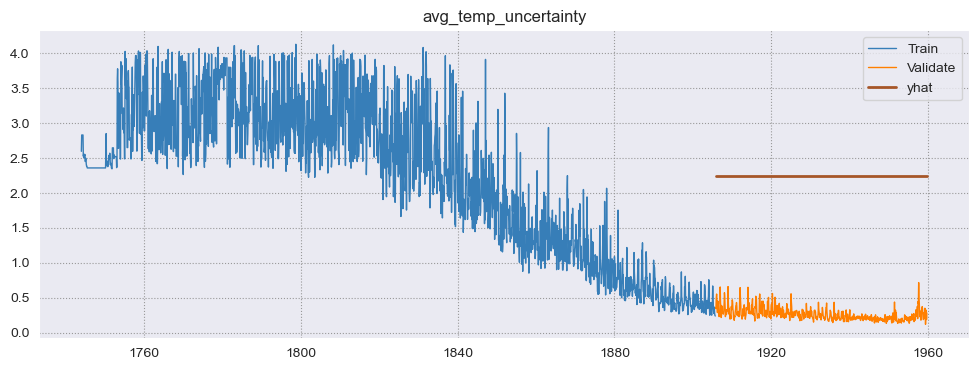

In [47]:
plot_and_eval(train, validate, yhat_df, col)

## moving average

In [48]:
period = 12
rolling_temp = round(train['avg_temp'].rolling(period).mean()[-1], 2)
rolling_temp_uncertainty = round(train['avg_temp_uncertainty'].rolling(period).mean()[-1], 2)

print(rolling_temp, rolling_temp_uncertainty)

10.28 0.35


In [49]:
yhat_df = make_baseline_predictions(rolling_temp, rolling_temp_uncertainty)

yhat_df.head()

,avg_temp,avg_temp_uncertainty
dt,,
1905-10-31,10.28,0.35
1905-11-30,10.28,0.35
1905-12-31,10.28,0.35
1906-01-31,10.28,0.35
1906-02-28,10.28,0.35


In [51]:
for col in train.columns:
    
    rmse = mod.evaluate(col, yhat_df, validate)
    
    eval_df = mod.append_eval_df('rolling_average', col,
                                    eval_df, rmse)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,11.48
1,last_observed_value,avg_temp_uncertainty,0.09
2,simple_average,avg_temp,8.63
3,simple_average,avg_temp_uncertainty,1.98
4,rolling_average,avg_temp,8.64
5,rolling_average,avg_temp_uncertainty,0.12


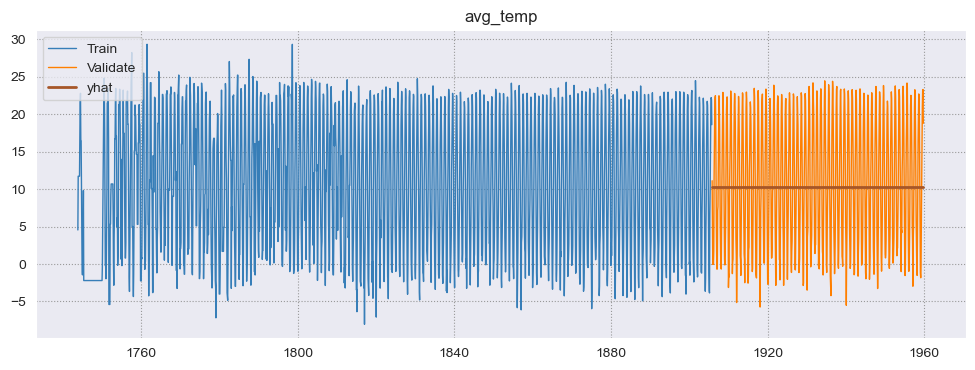

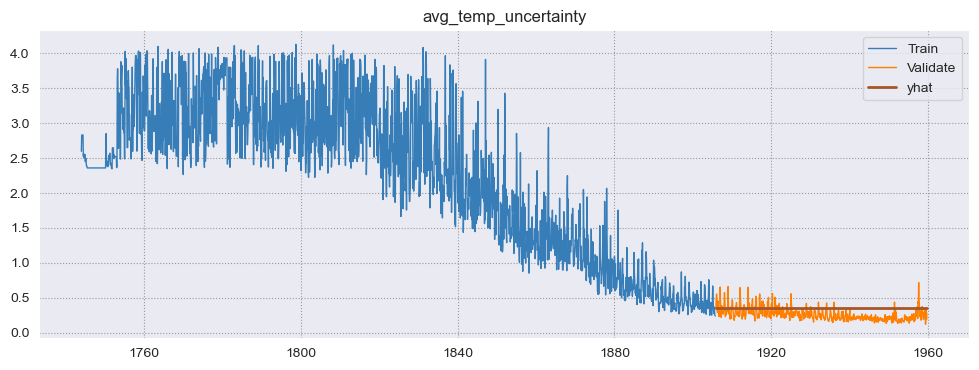

In [52]:
plot_and_eval(train, validate, yhat_df, col)

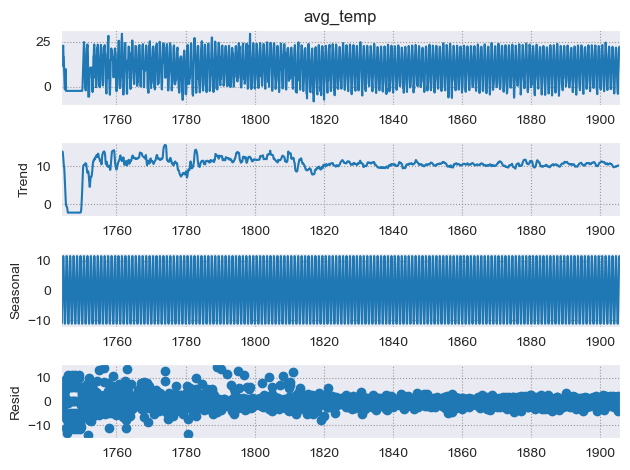

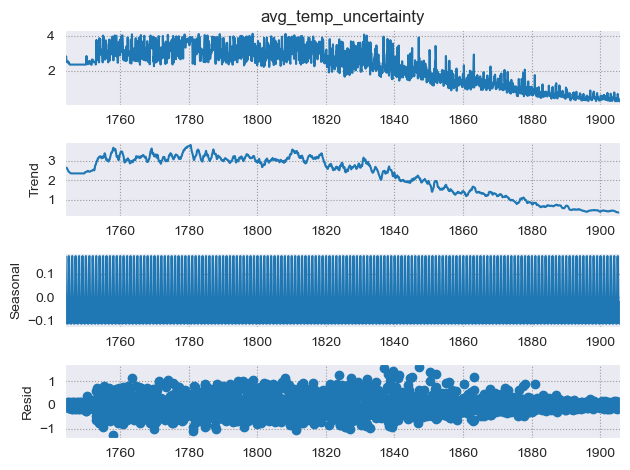

In [53]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('m').mean()).plot()

In [59]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

In [60]:
yhat_df

,avg_temp,avg_temp_uncertainty
dt,,
1905-10-31,16.78,0.36
1905-11-30,14.98,0.36
1905-12-31,13.53,0.36
1906-01-31,12.38,0.36
1906-02-28,11.45,0.36
...,...,...
1959-05-31,7.76,0.36
1959-06-30,7.76,0.36
1959-07-31,7.76,0.36


In [61]:
for col in train.columns:
    
    rmse = evaluate(col, yhat_df, validate)

    eval_df = mod.append_eval_df('holts_optimized', col,
                                   eval_df, rmse)

In [62]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,last_observed_value,avg_temp_uncertainty,0.09
5,rolling_average,avg_temp_uncertainty,0.12
7,holts_optimized,avg_temp_uncertainty,0.13
3,simple_average,avg_temp_uncertainty,1.98
2,simple_average,avg_temp,8.63
4,rolling_average,avg_temp,8.64
6,holts_optimized,avg_temp,9.23
0,last_observed_value,avg_temp,11.48


In [63]:
hst_avg_temp_fit1 = ExponentialSmoothing(train['avg_temp'], seasonal_periods=12, trend='add', seasonal='add').fit()
hst_avg_temp_fit3 = ExponentialSmoothing(train['avg_temp'], seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()


In [64]:
#hst_avg_temp_fit2 = ExponentialSmoothing(train['avg_temp'], seasonal_periods=12, trend='add', seasonal='mul').fit()
#hst_avg_temp_fit4 = ExponentialSmoothing(train['avg_temp'], seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()

In [65]:
hst_avg_temp_uncertainty_fit1 = ExponentialSmoothing(train.avg_temp_uncertainty, seasonal_periods=12, trend='add', seasonal='add').fit()
hst_avg_temp_uncertainty_fit3 = ExponentialSmoothing(train.avg_temp_uncertainty, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()


In [66]:
#hst_avg_temp_uncertainty_fit2 = ExponentialSmoothing(train.avg_temp_uncertainty, seasonal_periods=12, trend='add', seasonal='mul').fit()
#hst_avg_temp_uncertainty_fit4 = ExponentialSmoothing(train.avg_temp_uncertainty, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()

In [67]:
results_quantity = pd.DataFrame({'model':['hst_avg_temp_fit1', 'hst_avg_temp_fit3'],
                              'SSE':[hst_avg_temp_fit1.sse, hst_avg_temp_fit3.sse]})
results_quantity

,model,SSE
0,hst_avg_temp_fit1,16224.393152
1,hst_avg_temp_fit3,16079.914384


In [68]:
results_uncertainty = pd.DataFrame({'model':['hst_avg_temp_uncertainty_fit1', 'hst_avg_temp_uncertainty_fit3'],
                              'SSE':[hst_avg_temp_uncertainty_fit1.sse, hst_avg_temp_uncertainty_fit3.sse]})
results_uncertainty

,model,SSE
0,hst_avg_temp_uncertainty_fit1,340.213147
1,hst_avg_temp_uncertainty_fit3,340.256712


In [69]:
yhat_df = pd.DataFrame({'avg_temp': hst_avg_temp_fit1.forecast(validate.shape[0]),
                           'avg_temp_uncertainty': hst_avg_temp_uncertainty_fit1.forecast(validate.shape[0])},
                          index=validate.index)
yhat_df

,avg_temp,avg_temp_uncertainty
dt,,
1905-10-31,11.970540,0.289676
1905-11-30,5.241878,0.392306
1905-12-31,-0.502613,0.528556
1906-01-31,-2.017452,0.537473
1906-02-28,-1.571577,0.486329
...,...,...
1959-05-31,14.709742,-0.473373
1959-06-30,18.931012,-0.382797
1959-07-31,21.548292,-0.416865


In [70]:
for col in train.columns:
    
    rmse = mod.evaluate(col, yhat_df, validate)
    
    eval_df = mod.append_eval_df('holt_seasonal', col,
                                    eval_df, rmse)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,11.48
1,last_observed_value,avg_temp_uncertainty,0.09
2,simple_average,avg_temp,8.63
3,simple_average,avg_temp_uncertainty,1.98
4,rolling_average,avg_temp,8.64
5,rolling_average,avg_temp_uncertainty,0.12
6,holts_optimized,avg_temp,9.23
7,holts_optimized,avg_temp_uncertainty,0.13
8,holt_seasonal,avg_temp,1.75
9,holt_seasonal,avg_temp_uncertainty,0.33


In [71]:
yhat_df = pd.DataFrame({'avg_temp': hst_avg_temp_fit1.forecast(test.shape[0]),
                           'avg_temp_uncertainty': hst_avg_temp_uncertainty_fit1.forecast(test.shape[0])},
                          index=validate.index)
yhat_df

,avg_temp,avg_temp_uncertainty
dt,,
1905-10-31,11.970540,0.289676
1905-11-30,5.241878,0.392306
1905-12-31,-0.502613,0.528556
1906-01-31,-2.017452,0.537473
1906-02-28,-1.571577,0.486329
...,...,...
1959-05-31,14.709742,-0.473373
1959-06-30,18.931012,-0.382797
1959-07-31,21.548292,-0.416865


In [72]:
for col in train.columns:
    
    rmse = mod.evaluate(col, yhat_df, test)
    
    eval_df = mod.append_eval_df('holt_seasonal_test', col,
                                    eval_df, rmse)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,11.48
1,last_observed_value,avg_temp_uncertainty,0.09
2,simple_average,avg_temp,8.63
3,simple_average,avg_temp_uncertainty,1.98
4,rolling_average,avg_temp,8.64
5,rolling_average,avg_temp_uncertainty,0.12
6,holts_optimized,avg_temp,9.23
7,holts_optimized,avg_temp_uncertainty,0.13
8,holt_seasonal,avg_temp,1.75
9,holt_seasonal,avg_temp_uncertainty,0.33


In [73]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [74]:
rmse_avg_total = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

rmse_uncertainty = sqrt(mean_squared_error(test['avg_temp_uncertainty'], 
                                       yhat_df['avg_temp_uncertainty']))

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-avg_temp total:  1.955350884764771
rmse-uncertainty:  0.3259206432293105


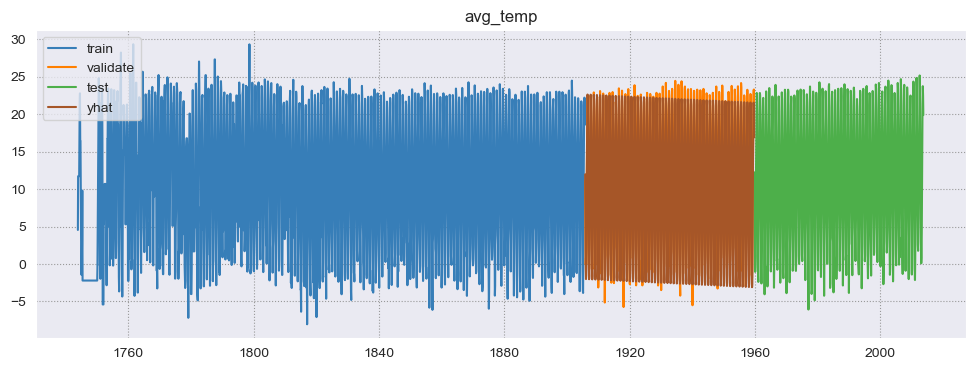

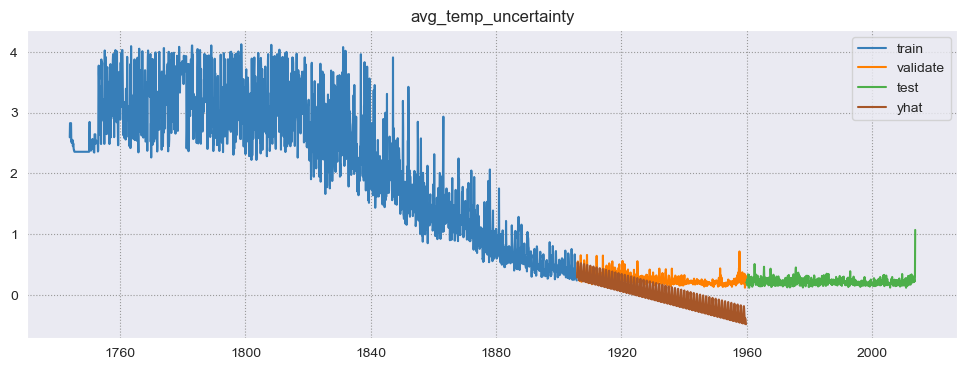

In [75]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-avg_temp total: ', rmse_avg_total)
print('rmse-uncertainty: ', rmse_uncertainty)
for col in train.columns:
    
    final_plot(col)

In [76]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,11.48
1,last_observed_value,avg_temp_uncertainty,0.09
2,simple_average,avg_temp,8.63
3,simple_average,avg_temp_uncertainty,1.98
4,rolling_average,avg_temp,8.64
5,rolling_average,avg_temp_uncertainty,0.12
6,holts_optimized,avg_temp,9.23
7,holts_optimized,avg_temp_uncertainty,0.13
8,holt_seasonal,avg_temp,1.75
9,holt_seasonal,avg_temp_uncertainty,0.33


# Takeaways:

- For this project, I honed in on the average temperatures and uncertainties for the continental United States.


- I created each of the three baselines gone over in class, of which, the simple average was very slightly better for the avg_temp, and the last observed was best for the uncertaintly level.


- After creating my baselines, I ran a holts optimized model, as well as several holts seasonal moodels. The first holt seasonal model I ran worked the best by far, so I moved into testing with that model.


- It performed slightly worse than the validate set, but still very well. The rmse ended up being 1.96 for the average temperature prediction on the test data, and the uncertainty was .33.


- Overall, it beat each of my baselines by quite a wide margin, so I am happy with this model, at least for prediction the near future.